In [1]:
import pandas as pd
import numpy as np

In [2]:
x = pd.read_csv ('../../data/fakenewzz/train.csv')
# y = pd.read_csv ('../../data/fakenewzz/test.csv')

In [3]:
x = x.dropna()

In [4]:
x.head (4)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1


In [5]:
y = x.label

In [6]:
vocab_size = 7000

In [7]:
import nltk
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [8]:
def text_preprocessing (txt):
    txt = txt.lower()
    # everthing excpect [a-zA-Z]
    txt = re.sub('[^a-zA-z]', ' ',txt)
    txt = txt.translate(str.maketrans ('', '', string.punctuation))
    txt = txt.strip()

    stop_words = set (stopwords.words('english'))

    stemmer = PorterStemmer()
    txt = stemmer.stem(txt)
    lemmatizer = WordNetLemmatizer()
    txt = lemmatizer.lemmatize(txt)

    txt = word_tokenize(txt)

    txt = [word for word in txt if word not in stop_words]
    return ' '.join(txt)

In [9]:
x.title = x.title.apply (text_preprocessing)

In [10]:
corpus = (x.title).tolist()

In [11]:
import tensorflow as tf

In [12]:
onehot_rep = [tf.keras.preprocessing.text.one_hot(word, vocab_size) for word in corpus]

In [13]:
for i in onehot_rep:
    if len(i) == 47:
        print (i)


[650, 6778, 5623, 6624, 2101, 3309, 1818, 5025, 794, 4651, 2632, 5683, 531, 4306, 640, 2015, 1708, 1877, 1011, 2257, 6898, 5573, 531, 160, 3253, 259, 6372, 209, 818, 5425, 5674, 5060, 2304, 4875, 1687, 4601, 6463, 6774, 5969, 371, 6897, 2788, 6014, 3496, 3591, 4270, 1884]


In [14]:
sent_len = [len(arr) for arr in onehot_rep]

In [15]:
max_padding = sent_len[len(sent_len) - 1]

In [16]:
padded_doc = tf.keras.preprocessing.sequence.pad_sequences(onehot_rep, maxlen = max_padding, padding = 'pre')

In [37]:
embedding_vector_features = 47
model = tf.keras.Sequential()
model.add (tf.keras.layers.Embedding(vocab_size, embedding_vector_features, input_length = max_padding))
model.add (tf.keras.layers.LSTM(64))
model.add (tf.keras.layers.Dense(1, activation = 'sigmoid'))

model.compile (loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 3, 47)             329000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                28672     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 357,737
Trainable params: 357,737
Non-trainable params: 0
_________________________________________________________________


In [19]:
import numpy as np
x_final = np.array (padded_doc)
y = np.array (y)

In [20]:
x_final.shape, y.shape

((18285, 3), (18285,))

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split (x_final, y, test_size = 0.33, random_state = 42)

In [38]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size = 256)

Epoch 1/10
48/48 [==============================] - 4s 30ms/step - loss: 0.6538 - accuracy: 0.6024 - val_loss: 0.4028 - val_accuracy: 0.8406
Epoch 2/10
48/48 [==============================] - 1s 16ms/step - loss: 0.3261 - accuracy: 0.8982 - val_loss: 0.2837 - val_accuracy: 0.8800
Epoch 3/10
48/48 [==============================] - 1s 16ms/step - loss: 0.1834 - accuracy: 0.9360 - val_loss: 0.2693 - val_accuracy: 0.8877
Epoch 4/10
48/48 [==============================] - 1s 16ms/step - loss: 0.1268 - accuracy: 0.9540 - val_loss: 0.2920 - val_accuracy: 0.8804
Epoch 5/10
48/48 [==============================] - 1s 17ms/step - loss: 0.1018 - accuracy: 0.9665 - val_loss: 0.3267 - val_accuracy: 0.8779
Epoch 6/10
48/48 [==============================] - 1s 16ms/step - loss: 0.0825 - accuracy: 0.9728 - val_loss: 0.3589 - val_accuracy: 0.8772
Epoch 7/10
48/48 [==============================] - 1s 16ms/step - loss: 0.0710 - accuracy: 0.9770 - val_loss: 0.3837 - val_accuracy: 0.8782
Epoch 8/10
48

In [39]:
import matplotlib.pyplot as plt
# plotting histroy w.r.t to a metric
def graph_plotter (hist, metric):
    plt.plot(hist.history[metric])
    plt.plot(hist.history['val_'+metric])
    plt.xlabel('epochs')
    plt.ylabel('metrics')
    plt.legend([metric, 'val_'+metric])

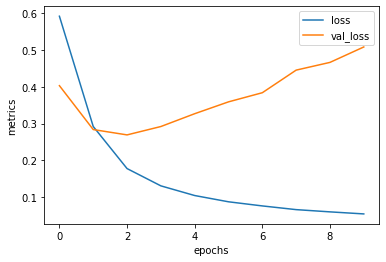

In [40]:
graph_plotter(hist, metric='loss')